#Ce fichier est repris du code du stagiaire précédent. 
#Dans un premier temps il permet de découper le jeu de données en BINs puis dans un second temps 
#Il permet de regrouper les BIN en liste et de concaténer ces listes de BINs afin de réaliser des analyses dessus


# Découpage du fichier de données en BINs

In [13]:
import math
import os
import re
import shutil
import sys
import warnings
from decimal import *

import chardet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from statistics import median

from constants import bins_axis_names, bin_dimensions_regex, boat_speed_feature, \
                    boxplot_axis_name, feature_regex, identifier_features, \
                    fiber_optics_structure_features, fiber_optics_appendix_features, \
                    other_sensor_features, statistics_features, wind_features

In [14]:
def read_csv(fnames):
    """Read CSV file(s) to a Pandas Dataframe"""
    def detect_and_read(fname):
        with open(fname, 'rb') as f:
            return pd.read_csv(fname, sep=';', encoding=chardet.detect(f.read())['encoding'])
    df = pd.concat(map(lambda fname: detect_and_read(fname), fnames), sort=False)
    return df

def sort_corr(corr, num_features=20):
    """Sort correlation dictionary"""
    sorted_corr = sorted(corr.items(), key=lambda x: abs(x[1]), reverse=True)[:num_features]
    sorted_corr = sorted(sorted_corr, key=lambda x: x[1], reverse=True)
    return sorted_corr

def compute_sorted_corr(df, target_feature=boat_speed_feature[1], num_features=20):
    """Compute sorted correlated features with the target feature"""
    corr = {}
    for col in df.columns:
        if col != target_feature:
            f_corr = df[target_feature].corr(df[col])
            if not math.isnan(f_corr):
                corr[col] = f_corr
    cols = [target_feature] + [x[0] for x in sort_corr(corr)]
    if len(cols) <= 1:
        return None, None
    return df[cols].corr(), corr

def create_bins(df,
                wind_features=[x[1] for x in wind_features],
                target_feature=boat_speed_feature[1],
                statistics_cols=statistics_features,
                dx=5, dy=2, min_thresh=5,
                exclude=[x[1] for x in identifier_features + wind_features]):
    """Create bins"""
    bins, corr = {}, {}
    for max_x in range(-180, 180, dx):
        for max_y in range(0, math.ceil(df[wind_features[1]].max()), dy):
            query = '{0} >= {2} and {0} < {2}+{4} and {1} >= {3} and {1} < {3}+{5}' \
                        .format(wind_features[0], wind_features[1], max_x, max_y, dx, dy)
            binned_df = df.query(query)
            bin_size = len(binned_df.index)
            bin_corr, unsorted_corr = compute_sorted_corr(binned_df.drop(exclude, axis=1))
            if bin_size >= min_thresh and bin_corr is not None:
                bin_name = 'bin_x{}to{}_y{}to{}'.format(max_x, max_x+dx, max_y, max_y+dy)
                for col, c_corr in unsorted_corr.items():
                    if col in corr:
                        corr[col].append(c_corr)
                    else:
                        corr[col] = [c_corr]
                bins[bin_name] = {'bin': binned_df, 'size': bin_size, 'corr': bin_corr}
    sorted_corr_df = pd.DataFrame(data=sort_corr({col: median(c_corr) for col, c_corr in corr.items()}), columns=statistics_cols)
    return bins, dx, dy, max_x, max_y, sorted_corr_df

def plot_wind_angle_speed(df, x_start, y_start, x_finish, y_finish, dx, dy, markersize,
                        wind_features=[x[1] for x in wind_features],
                        axis_names=bins_axis_names,
                        main=False):
    """Plot the wind angle-speed space"""
    _, ax = plt.subplots()
    ax.set_xlabel(axis_names[0])
    ax.set_ylabel(axis_names[1])
    ax.plot(df[wind_features[0]].tolist(), df[wind_features[1]].tolist(), 'ko', markersize=markersize)
    if main:
        ax.set_xticks(np.arange(x_start, x_finish, dx*6))
        ax.set_xticks(np.arange(x_start, x_finish, dx), minor=True)
        ax.set_yticks(np.arange(y_start, y_finish, dy))
        ax.grid(which='both', lw=.75)
    else:
        ax.set_xlim(x_start, x_finish)
        ax.set_ylim(y_start, y_finish)
        ax.grid(lw=.75)
    plt.tight_layout()
    plt.show()
    plt.clf()

def plot_boxplot(df,
                target_feature=boat_speed_feature[1],
                axis_name=boxplot_axis_name):
    """Plot the boxplot for boat speed"""
    ax = df.boxplot(column=target_feature,
                    showfliers=df[target_feature].median() == df[target_feature].mode().iloc[0],
                    return_type='axes')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.set_ylabel(axis_name)
    plt.tight_layout()
    plt.show()
    plt.clf()

def plot_corr(corr):
    """Plot the correlations with boat speed"""
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, lw=.75)
    plt.xticks(rotation=30, ha='right', fontsize=5)
    plt.yticks(fontsize=5)
    plt.tight_layout()
    plt.show()
    plt.clf()

In [3]:
# Ignore RunTimeWarning.
#warnings.filterwarnings('ignore')

# Ignore PyPlot warning.
#plt.rcParams.update({'figure.max_open_warning': 0})

# Version number.
#version = 'v2'

In [9]:
# Lecture du fichier
df = pd.read_csv('final_data2.csv', sep = ';')

C:\Users\Bonjour\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Bonjour\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


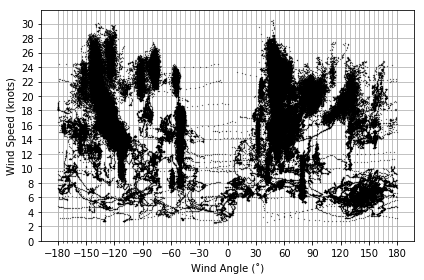

<Figure size 432x288 with 0 Axes>

In [15]:
# Creation des Bins. Taille par défaut :  5˚ par 2 noeuds.
bins, dx, dy, _, max_y, sorted_corr_df = create_bins(df)

# Graphique des Bins
croquis = plot_wind_angle_speed(df, -180, 0, 180+1, max_y+1, dx, dy, 0.25, main=True)

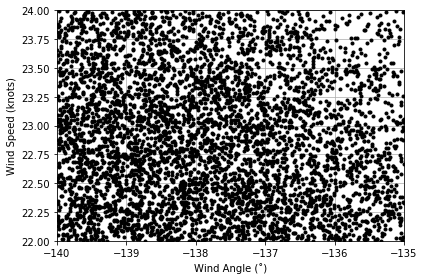

<Figure size 432x288 with 0 Axes>

In [22]:
# Graphique d'un seul BIN. (-140 to -135, 22 à 24 noeuds)
bin_name = 'bin_x-140to-135_y22to24'
binned_df, bin_corr = bins[bin_name]['bin'], bins[bin_name]['corr']
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0
#Graphqiue du BIN.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish, y_finish, dx, dy, 3)
BINm140m135_22to24 = binned_df

In [10]:
#Regroupement de plusieurs BINs dans une liste

BIN1 = ['bin_x50to55_y20to22',
        'bin_x50to55_y22to24',
        'bin_x50to55_y24to26',
        'bin_x50to55_y26to28',
        'bin_x55to60_y20to22',
        'bin_x55to60_y22to24',
        'bin_x55to60_y24to26',
        'bin_x55to60_y26to28',
        'bin_x60to65_y20to22',
        'bin_x60to65_y22to24',
        'bin_x60to65_y24to26',
        'bin_x60to65_y26to28',
        'bin_x65to70_y20to22',
        'bin_x65to70_y22to24',
        'bin_x65to70_y24to26',
        'bin_x70to75_y20to22',
        'bin_x70to75_y22to24',
        'bin_x75to80_y20to22',
        'bin_x75to80_y22to24',
        'bin_x80to85_y20to22',
        'bin_x80to85_y22to24',
        'bin_x80to85_y24to26',
        'bin_x85to90_y20to22',
        'bin_x85to90_y22to24',
        'bin_x90to95_y20to22',
        'bin_x90to95_y22to24',
        'bin_x90to95_y24to26',
        'bin_x95to100_y20to22',
        'bin_x95to100_y22to24',
        'bin_x95to100_y24to26'
       ]

In [8]:
#Fonction de création des Bins
def toBin(binn) :
    bin_name = binn
    binned_df, bin_corr = bins[bin_name]['bin'], bins[bin_name]['corr']
    x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
    dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0
    return binned_df    

In [11]:
#Regroupement des Bins de la liste dans un même fichier
mybin = pd.DataFrame()
for x in BIN1 : 
    mybin1 = pd.concat([mybin1, toBin(x)])
mybin1.shape
mybin1.to_csv('mybin1.csv',sep=';')